# 0. Objective

### This work aims to use deep learning image recognition techniques to train a model to identify the most commercially common nine aircraft variant families and use the trained model to predict the variant family of new aircraft images.

In [53]:
#imports

#system
import os

#math
import numpy as np
import pandas as pd

#DL
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B1
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.regularizers import l2


#visualization and reporting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 1. Importing the dataset and constructing the training and valadation datasets

In [54]:
training_directory_url = "/kaggle/input/split-balanced-data-final-removed-v3/split_balanced_data_final_removed_v3/train"
val_directory_url = "/kaggle/input/split-balanced-data-final-removed-v3/split_balanced_data_final_removed_v3/validation"
test_directory_url = "/kaggle/input/split-balanced-data-final-removed-v3/split_balanced_data_final_removed_v3/test"

In [55]:
Xy_train = image_dataset_from_directory(
    directory= training_directory_url,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 1800 files belonging to 9 classes.


In [56]:
Xy_val = image_dataset_from_directory(
    directory= val_directory_url,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)

Found 900 files belonging to 9 classes.


# 2. Preprocessing test and validation dataset

In [ ]:
Xy_train_preprocessed = Xy_train.map(lambda x, y: (preprocess_input(x), y))
Xy_val_preprocessed = Xy_val.map(lambda x, y: (preprocess_input(x), y))

# 3. Selecting a transfer learning model and constructing the DL model

In [57]:
# Transfer learning

tl_model = EfficientNetV2B1(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False

In [58]:
# Deep learning model

model = Sequential([
    RandomFlip('horizontal'),
    tl_model,
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.011)),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.011)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

# 4. Training the DL model

In [61]:
# Setting callback paramters

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=4,           
    restore_best_weights=True  
)

lr = ReduceLROnPlateau(monitor="val_loss",
                       factor=0.1,
                       patience=2,
                       verbose=1,
                       min_lr=0)

mcp = ModelCheckpoint("{}.h5".format('model_name'),
                      save_weights_only=False,
                      monitor='val_accuracy',
                      mode='max',
                      verbose=0,
                      save_best_only=True)


In [62]:
opt = optimizers.Adam(learning_rate=1e-4)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


history = model.fit(
    Xy_train_preprocessed,
    epochs=100,  
    validation_data=Xy_val_preprocessed,
    verbose=0,
    callbacks=[early_stopping, lr, mcp]
)

2023-09-11 10:07:04.656181: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetv2-b1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 78: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 80: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


# 5. Validating the DL model

In [63]:
# Evaluate the model on the validation dataset
accuracy = model.evaluate(Xy_val_preprocessed, verbose=1)

# Print the accuracy
print(f"Validation Accuracy: {accuracy[1] * 100:.2f}%")

29/29 [==============================] - 5s 142ms/step - loss: 0.5008 - accuracy: 0.9411
Validation Accuracy: 94.11%


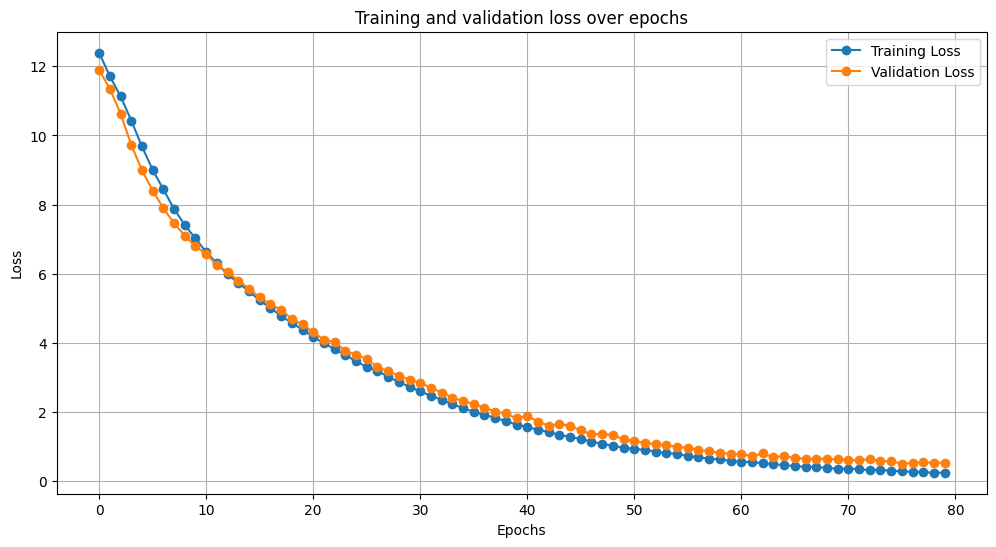

In [64]:
# Plotting loss curve

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training and validation loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 6. Testing the DL model

In [65]:
# Constructing the test dataset for evaluation with shuffling enabled similar to the training set

Xy_test = image_dataset_from_directory(
    directory= test_directory_url,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)

Xy_test_preprocessed = Xy_test.map(lambda x, y: (preprocess_input(x), y))

Found 900 files belonging to 9 classes.


In [66]:
test_result = model.evaluate(Xy_test_preprocessed, verbose=1)

29/29 [==============================] - 6s 143ms/step - loss: 0.4566 - accuracy: 0.9433


# 7. Reporting

In [67]:
# Reconstructing the test set without schuffling to use it in writing the classification report

Xy_test_unshuffled = image_dataset_from_directory(
    directory= test_directory_url,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=False, 
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)

Xy_test_preproc_unshuffled = Xy_test_unshuffled.map(lambda x, y: (preprocess_input(x), y))

Found 900 files belonging to 9 classes.


In [68]:
# Prediction

y_pred_encoded = model.predict(Xy_test_preproc_unshuffled, batch_size=32)
y_pred_class_num = np.argmax(y_pred_encoded, axis=1)
Xy_test_preprocessed_unbatched = Xy_test_preprocessed.unbatch()
y_true_encoded = np.array(list(Xy_test_preprocessed_unbatched.map(lambda x, y:  y)))
y_true= np.argmax(y_true_encoded, axis=1)

29/29 [==============================] - 7s 178ms/step


In [69]:
# Writing classification report

classes = ['737', '747','767','A340','CRJ','DC','DHC','E','MD']
report = classification_report(y_true, y_pred_class_num, target_names=classes)
print(report)

              precision    recall  f1-score   support

         737       0.91      0.95      0.93       100
         747       0.90      0.89      0.89       100
         767       0.92      0.91      0.91       100
        A340       0.98      0.88      0.93       100
         CRJ       0.96      0.98      0.97       100
          DC       0.92      0.98      0.95       100
         DHC       0.95      0.99      0.97       100
           E       0.99      0.95      0.97       100
          MD       0.96      0.96      0.96       100

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



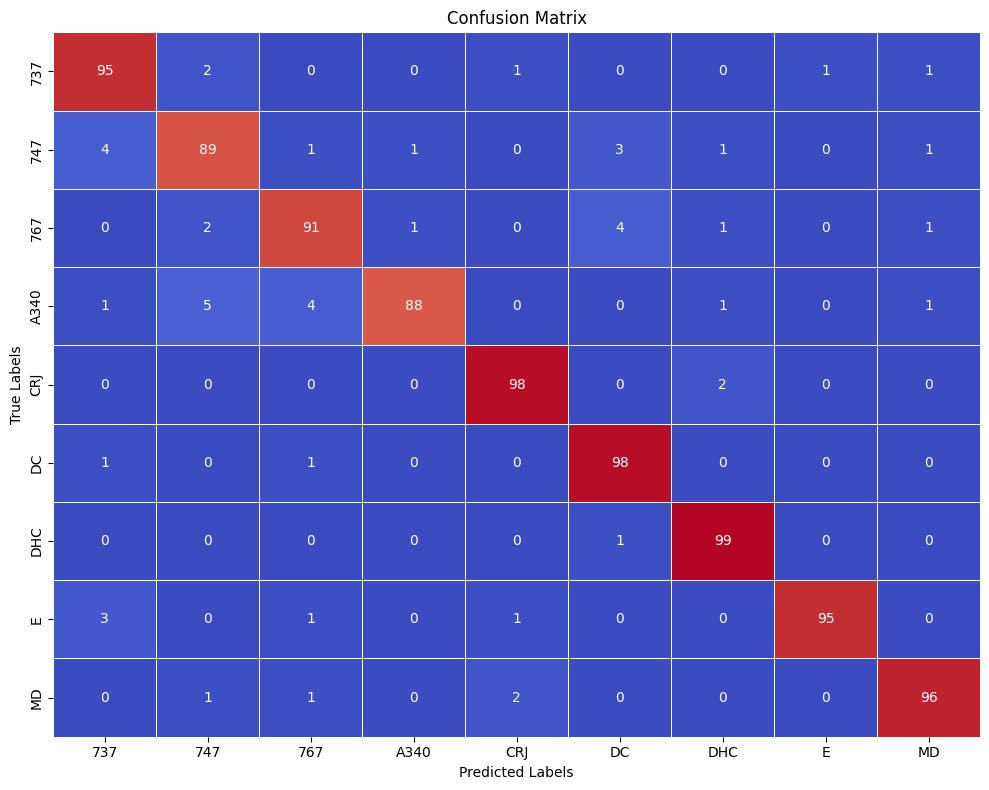

In [70]:
# Constructing confusion matrix

classes = ['737', '747', '767', 'A340', 'CRJ', 'DC', 'DHC', 'E', 'MD']
cm = confusion_matrix(y_true=y_true, y_pred=y_pred_class_num)
df_cm = pd.DataFrame(cm, columns=classes, index=classes)

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(df_cm, annot=True, cmap='coolwarm', fmt='d', linewidths=0.5, cbar=False, ax=ax)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Final notes

- The model shows good performance with 94% accuracy on both validation and test sets
- As seen from the confusion matrix, the accuracy of predicting individual classes varies in the range of 88-99%. This can also be considered as the probability of true positive predictions per class, since the test dataset has 100 datapoint per class.
- A front end app is made available to use the model for predicting aircraft image classes. The app is accessible [here](http://).
